In [1]:
suppressPackageStartupMessages({
    require(igraph)
    library(dplyr)
    library(ggvenn)
    library(tidyr)
    library(ggpubr)
    library(rstatix)
})

In [3]:
species <- c('Hsap','Mmus','Pvit', 'Pmar')

duplicate_pairs <- readRDS("Combined.SSD_WGD.rds")
Hsap2Mmus <- read.table("/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/02.gene_relationships/run4/results/Ortho_pipeline/OrthoFinder/RBH_results/RBH.Hsap.Mmus.tsv", header = T)
Mmus2Hsap <- read.table("/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/02.gene_relationships/run4/results/Ortho_pipeline/OrthoFinder/RBH_results/RBH.Mmus.Hsap.tsv", header = T)
Hsap2Pvit <- read.table("/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/02.gene_relationships/run4/results/Ortho_pipeline/OrthoFinder/RBH_results/RBH.Hsap.Pvit.tsv", header = T)
Pvit2Hsap <- read.table("/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/02.gene_relationships/run4/results/Ortho_pipeline/OrthoFinder/RBH_results/RBH.Pvit.Hsap.tsv", header = T)
Mmus2Pvit <- read.table("/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/02.gene_relationships/run4/results/Ortho_pipeline/OrthoFinder/RBH_results/RBH.Mmus.Pvit.tsv", header = T)
Pvit2Mmus <- read.table("/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/02.gene_relationships/run4/results/Ortho_pipeline/OrthoFinder/RBH_results/RBH.Pvit.Mmus.tsv", header = T)

Hsap2Pmar <- read.table("/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/02.gene_relationships/run4/results/Ortho_pipeline/OrthoFinder/RBH_results/RBH.Hsap.Pmar.tsv", header = T)
Pmar2Hsap <- read.table("/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/02.gene_relationships/run4/results/Ortho_pipeline/OrthoFinder/RBH_results/RBH.Pmar.Hsap.tsv", header = T)
Mmus2Pmar <- read.table("/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/02.gene_relationships/run4/results/Ortho_pipeline/OrthoFinder/RBH_results/RBH.Mmus.Pmar.tsv", header = T)
Pmar2Mmus <- read.table("/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/02.gene_relationships/run4/results/Ortho_pipeline/OrthoFinder/RBH_results/RBH.Pmar.Mmus.tsv", header = T)
Pvit2Pmar <- read.table("/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/02.gene_relationships/run4/results/Ortho_pipeline/OrthoFinder/RBH_results/RBH.Pvit.Pmar.tsv", header = T)
Pmar2Pvit <- read.table("/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/02.gene_relationships/run4/results/Ortho_pipeline/OrthoFinder/RBH_results/RBH.Pmar.Pvit.tsv", header = T)


# pay attention, hsap2mmus just species linkage orthologs, not dup1 not dup2 
colnames(Hsap2Mmus) <- c("dup1","dup2")
colnames(Mmus2Hsap) <- c("dup1","dup2")
colnames(Hsap2Pvit) <- c("dup1","dup2")
colnames(Pvit2Hsap) <- c("dup1","dup2")
colnames(Mmus2Pvit) <- c("dup1","dup2")
colnames(Pvit2Mmus) <- c("dup1","dup2")
colnames(Hsap2Pmar) <- c("dup1","dup2")
colnames(Pmar2Hsap) <- c("dup1","dup2")
colnames(Mmus2Pmar) <- c("dup1","dup2")
colnames(Pmar2Mmus) <- c("dup1","dup2")
colnames(Pvit2Pmar) <- c("dup1","dup2")
colnames(Pmar2Pvit) <- c("dup1","dup2")

orthologs <- rbind(Hsap2Mmus,Mmus2Hsap,Hsap2Pvit,Pvit2Hsap,Mmus2Pvit,Pvit2Mmus,
                   Hsap2Pmar,Pmar2Hsap,Mmus2Pmar,Pmar2Mmus,Pvit2Pmar,Pmar2Pvit)

In [8]:
Amniote_homologous_celltypes <- read.delim('/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/01.data/02.atlas_final/3.plotting/8.plot_dotplot_cross_species/celltype_ordering.v2.txt', header = F)$V1
Vertebrate_homologous_celltypes <- Amniote_homologous_celltypes[!Amniote_homologous_celltypes %in% 
                                                                c('Oligodendrocyte precursor cells','Oligodendrocytes')]

In [4]:
# combined paralogs and orthologs file together, and build graph
Combined_pairs_ssd <- duplicate_pairs %>% filter(species %in% species & type == "SSD") %>% select(c("dup1", "dup2"))
Combined_pairs_wgd <- duplicate_pairs %>% filter(species %in% species & type == "WGD") %>% select(c("dup1", "dup2"))

Combined_pairs_ssd <- rbind(orthologs, Combined_pairs_ssd)
Combined_pairs_wgd <- rbind(orthologs, Combined_pairs_wgd)

In [5]:
background <- readRDS("/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/04.ohno_para_significance/0bin/gene_bg.rds")

In [6]:
# genes in our dataset
Combined_pairs_ssd <- Combined_pairs_ssd[Combined_pairs_ssd$dup1 %in% background$gene & 
                                 Combined_pairs_ssd$dup2 %in% background$gene, ]
Combined_pairs_wgd <- Combined_pairs_wgd[Combined_pairs_wgd$dup1 %in% background$gene & 
                                 Combined_pairs_wgd$dup2 %in% background$gene, ]

In [7]:
# get SSD/WGD families
g <- graph_from_data_frame(Combined_pairs_ssd, directed = FALSE)
components <- components(g)$membership
SSD_pairs <- split(names(components), components)
g <- graph_from_data_frame(Combined_pairs_wgd, directed = FALSE)
components <- components(g)$membership
WGD_pairs <- split(names(components), components)

In [8]:
# get expression domain based on tri score
markers <- readRDS("exp_domain/combined.exp_tri_score.rds")

In [10]:
# function to get family, marker, and orthologs information 
get_family_switching <- function(family, clusters, markers, species1, species2, orthologs){
    # filter WGD/SSD pairs to contain only two species
    bg_tmp <- background %>% filter(species %in% c(species1, species2))
    select <- lapply(seq_along(family), FUN = function(i){
        x = family[[i]]
        names(x) <- bg_tmp[match(x, bg_tmp$gene), "species"]
        if ( sum(table(names(x)) >1) >0){
            return(i)
        }
    })
    family <- family[unlist(select)]
    family <- lapply(family, FUN = function(i){
        return(i[i %in% bg_tmp$gene]) # remove other species gene ID
    })
    
    # filter markers to contain only two species
    markers <- markers %>% filter(species %in% c(species1, species2))

    info <- Reduce(rbind, lapply(clusters, FUN = function(c){
        # filter to contain markers
        markers_tmp <- unique(unlist(markers %>% filter(cluster == c) %>% select("gene")))
        select <- lapply(seq_along(family), FUN = function(i){
            x = family[[i]]
            if (sum( x %in% markers_tmp)){ # contain marker(s)
                return(i)
            }
        })
        family_sub <- family[unlist(select)]
        
        info <- Reduce(rbind, lapply(names(family_sub), FUN = function(x){
            pairs <- family_sub[[x]]
            results <- data.frame(gene = pairs, markers = FALSE, species = NA)
            results$markers <- pairs %in% markers_tmp
            results$species <- bg_tmp[match(pairs, bg_tmp$gene), "species"]
            #results$gene <- ID2name[match(pairs, ID2name$Gene.stable.ID), "Gene.name"]
            results$orthogroup_index <- x
            results$cluster <- c
            results$orthologs <- ifelse(pairs %in% orthologs$dup1, orthologs[match(pairs, orthologs$dup1), 2], 
                                    ifelse(pairs %in% orthologs$dup2, orthologs[match(pairs, orthologs$dup2), 1], FALSE))
            results$orthologs_is_marker <- results[match(results$orthologs, results$gene), "markers"]
            return(results)
        }))
        return(info)
    }))
    return(info)
}

In [13]:
info_wgd_Hsap2Mmus <- get_family_switching(family = WGD_pairs, clusters = unique(markers$cluster), markers, species1 = "Hsap", species2 = "Mmus", orthologs = Hsap2Mmus)
info_ssd_Hsap2Mmus <- get_family_switching(family = SSD_pairs, clusters = unique(markers$cluster), markers, species1 = "Hsap", species2 = "Mmus", orthologs = Hsap2Mmus)

info_wgd_Hsap2Pvit <- get_family_switching(family = WGD_pairs, clusters = unique(markers$cluster), markers, species1 = "Hsap", species2 = "Pvit", orthologs = Hsap2Pvit)
info_ssd_Hsap2Pvit <- get_family_switching(family = SSD_pairs, clusters = unique(markers$cluster), markers, species1 = "Hsap", species2 = "Pvit", orthologs = Hsap2Pvit)

info_wgd_Mmus2Pvit <- get_family_switching(family = WGD_pairs, clusters = unique(markers$cluster), markers, species1 = "Mmus", species2 = "Pvit", orthologs = Mmus2Pvit)
info_ssd_Mmus2Pvit <- get_family_switching(family = SSD_pairs, clusters = unique(markers$cluster), markers, species1 = "Mmus", species2 = "Pvit", orthologs = Mmus2Pvit)

info_wgd_Hsap2Pmar <- get_family_switching(family = WGD_pairs, clusters = unique(markers$cluster), markers, species1 = "Hsap", species2 = "Pmar", orthologs = Hsap2Pmar)
info_ssd_Hsap2Pmar <- get_family_switching(family = SSD_pairs, clusters = unique(markers$cluster), markers, species1 = "Hsap", species2 = "Pmar", orthologs = Hsap2Pmar)

info_wgd_Mmus2Pmar <- get_family_switching(family = WGD_pairs, clusters = unique(markers$cluster), markers, species1 = "Mmus", species2 = "Pmar", orthologs = Mmus2Pmar)
info_ssd_Mmus2Pmar <- get_family_switching(family = SSD_pairs, clusters = unique(markers$cluster), markers, species1 = "Mmus", species2 = "Pmar", orthologs = Mmus2Pmar)

info_wgd_Pvit2Pmar <- get_family_switching(family = WGD_pairs, clusters = unique(markers$cluster), markers, species1 = "Pvit", species2 = "Pmar", orthologs = Pvit2Pmar)
info_ssd_Pvit2Pmar <- get_family_switching(family = SSD_pairs, clusters = unique(markers$cluster), markers, species1 = "Pvit", species2 = "Pmar", orthologs = Pvit2Pmar)


In [12]:
head(info_wgd_Hsap2Mmus)

,gene,markers,species,orthogroup_index,cluster,orthologs,orthologs_is_marker
,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<lgl>
1,ENSG00000167772,TRUE,Hsap,29,Astrocytes,Angptl4,FALSE
2,ENSG00000171560,FALSE,Hsap,29,Astrocytes,Fga,FALSE
3,ENSG00000130720,FALSE,Hsap,29,Astrocytes,Fibcd1,FALSE
4,ENSG00000136859,FALSE,Hsap,29,Astrocytes,Angptl2,FALSE
5,ENSG00000116194,FALSE,Hsap,29,Astrocytes,Angptl1,FALSE
6,ENSG00000130812,FALSE,Hsap,29,Astrocytes,Angptl6,FALSE


In [14]:
# calculate the ratio of paralog switching
details_switching_wgd_Hsap2Mmus <- info_wgd_Hsap2Mmus %>% group_by(cluster, orthogroup_index) %>% 
    summarise(
        shared = ifelse( sum(markers == TRUE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0,"YES", "NO"),
        switching = ifelse( sum(markers == FALSE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0, "YES", "NO"),
        species = "Hsap_vs_Mmus", type = "WGD"
        ) %>% ungroup()
details_switching_ssd_Hsap2Mmus <- info_ssd_Hsap2Mmus %>% group_by(cluster, orthogroup_index) %>% 
    summarise(
        shared = ifelse( sum(markers == TRUE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0,"YES", "NO"),
        switching = ifelse( sum(markers == FALSE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0, "YES", "NO"),
        species = "Hsap_vs_Mmus", type = "SSD"
        ) %>% ungroup()

details_switching_wgd_Hsap2Pvit <- info_wgd_Hsap2Pvit %>% group_by(cluster, orthogroup_index) %>% 
    summarise(
        shared = ifelse( sum(markers == TRUE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0,"YES", "NO"),
        switching = ifelse( sum(markers == FALSE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0, "YES", "NO"),
        species = "Hsap_vs_Pvit", type = "WGD"
        ) %>% ungroup()
details_switching_ssd_Hsap2Pvit <- info_ssd_Hsap2Pvit %>% group_by(cluster, orthogroup_index) %>% 
    summarise(
        shared = ifelse( sum(markers == TRUE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0,"YES", "NO"),
        switching = ifelse( sum(markers == FALSE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0, "YES", "NO"),
        species = "Hsap_vs_Pvit", type = "SSD"
        ) %>% ungroup()

details_switching_wgd_Mmus2Pvit <- info_wgd_Mmus2Pvit %>% group_by(cluster, orthogroup_index) %>% 
    summarise(
        shared = ifelse( sum(markers == TRUE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0,"YES", "NO"),
        switching = ifelse( sum(markers == FALSE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0, "YES", "NO"),
        species = "Mmus_vs_Pvit", type = "WGD"
        ) %>% ungroup()
details_switching_ssd_Mmus2Pvit <- info_ssd_Mmus2Pvit %>% group_by(cluster, orthogroup_index) %>% 
    summarise(
        shared = ifelse( sum(markers == TRUE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0,"YES", "NO"),
        switching = ifelse( sum(markers == FALSE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0, "YES", "NO"),
        species = "Mmus_vs_Pvit", type = "SSD"
        ) %>% ungroup()


details_switching_wgd_Hsap2Pmar <- info_wgd_Hsap2Pmar %>% group_by(cluster, orthogroup_index) %>% 
    summarise(
        shared = ifelse( sum(markers == TRUE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0,"YES", "NO"),
        switching = ifelse( sum(markers == FALSE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0, "YES", "NO"),
        species = "Hsap_vs_Pmar", type = "WGD"
        ) %>% ungroup()
details_switching_ssd_Hsap2Pmar <- info_ssd_Hsap2Pmar %>% group_by(cluster, orthogroup_index) %>% 
    summarise(
        shared = ifelse( sum(markers == TRUE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0,"YES", "NO"),
        switching = ifelse( sum(markers == FALSE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0, "YES", "NO"),
        species = "Hsap_vs_Pmar", type = "SSD"
        ) %>% ungroup()

details_switching_wgd_Mmus2Pmar <- info_wgd_Mmus2Pmar %>% group_by(cluster, orthogroup_index) %>% 
    summarise(
        shared = ifelse( sum(markers == TRUE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0,"YES", "NO"),
        switching = ifelse( sum(markers == FALSE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0, "YES", "NO"),
        species = "Mmus_vs_Pmar", type = "WGD"
        ) %>% ungroup()
details_switching_ssd_Mmus2Pmar <- info_ssd_Mmus2Pmar %>% group_by(cluster, orthogroup_index) %>% 
    summarise(
        shared = ifelse( sum(markers == TRUE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0,"YES", "NO"),
        switching = ifelse( sum(markers == FALSE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0, "YES", "NO"),
        species = "Mmus_vs_Pmar", type = "SSD"
        ) %>% ungroup()

details_switching_wgd_Pvit2Pmar <- info_wgd_Pvit2Pmar %>% group_by(cluster, orthogroup_index) %>% 
    summarise(
        shared = ifelse( sum(markers == TRUE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0,"YES", "NO"),
        switching = ifelse( sum(markers == FALSE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0, "YES", "NO"),
        species = "Pvit_vs_Pmar", type = "WGD"
        ) %>% ungroup()
details_switching_ssd_Pvit2Pmar <- info_ssd_Pvit2Pmar %>% group_by(cluster, orthogroup_index) %>% 
    summarise(
        shared = ifelse( sum(markers == TRUE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0,"YES", "NO"),
        switching = ifelse( sum(markers == FALSE & orthologs_is_marker == TRUE, na.rm = TRUE) > 0, "YES", "NO"),
        species = "Pvit_vs_Pmar", type = "SSD"
        ) %>% ungroup()



details_switching <- rbind(details_switching_wgd_Hsap2Mmus, details_switching_ssd_Hsap2Mmus,
                          details_switching_wgd_Hsap2Pvit, details_switching_ssd_Hsap2Pvit,
                          details_switching_wgd_Mmus2Pvit, details_switching_ssd_Mmus2Pvit,
                          details_switching_wgd_Hsap2Pmar, details_switching_ssd_Hsap2Pmar,
                          details_switching_wgd_Mmus2Pmar, details_switching_ssd_Mmus2Pmar,
                          details_switching_wgd_Pvit2Pmar, details_switching_ssd_Pvit2Pmar
                          )

`summarise()` has grouped output by 'cluster'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'cluster'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'cluster'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'cluster'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'cluster'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'cluster'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'cluster'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'cluster'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'cluster'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'cluster'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'cluster'. You can overr

In [15]:
tail(details_switching)

cluster,orthogroup_index,shared,switching,species,type
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Vascular cells,988,YES,NO,Pvit_vs_Pmar,SSD
Vascular cells,99,NO,YES,Pvit_vs_Pmar,SSD
Vascular cells,991,NO,YES,Pvit_vs_Pmar,SSD
Vascular cells,994,NO,NO,Pvit_vs_Pmar,SSD
Vascular cells,995,YES,YES,Pvit_vs_Pmar,SSD
Vascular cells,998,NO,NO,Pvit_vs_Pmar,SSD


In [3]:
switching_pct <- details_switching %>% group_by(species, type, cluster) %>% summarise(
    total_number = n(),
    #both = sum(shared == "YES" & switching == "YES", na.rm = TRUE)/total_number,
    shared = sum(shared == "YES", na.rm = TRUE)/total_number,
    switching = sum(switching == "YES", na.rm = TRUE)/total_number
) %>% ungroup()

`summarise()` has grouped output by 'species', 'type'. You can override using
the `.groups` argument.


In [4]:
head(switching_pct)

species,type,cluster,total_number,shared,switching
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
Hsap_vs_Mmus,SSD,Astrocytes,1712,0.2862150,0.7207944
Hsap_vs_Mmus,SSD,Choroid plexus epithelial cells,2203,0.5342714,0.5215615
Hsap_vs_Mmus,SSD,Diencephalon GABAergic neurons,2269,0.6011459,0.4543852
Hsap_vs_Mmus,SSD,Diencephalon cholinergic neurons,2028,0.0000000,0.9097633
Hsap_vs_Mmus,SSD,Diencephalon glutamatergic neurons,2395,0.6004175,0.4605428
Hsap_vs_Mmus,SSD,Ependymal cells,2111,0.5466604,0.5286594


In [5]:
switching_pct$type <- factor(switching_pct$type, levels = c("WGD", "SSD"))
switching_pct$species <- factor(switching_pct$species, 
                                levels = c("Hsap_vs_Mmus", "Hsap_vs_Pvit", "Mmus_vs_Pvit", 
                                           "Hsap_vs_Pmar", "Mmus_vs_Pmar", "Pvit_vs_Pmar"))

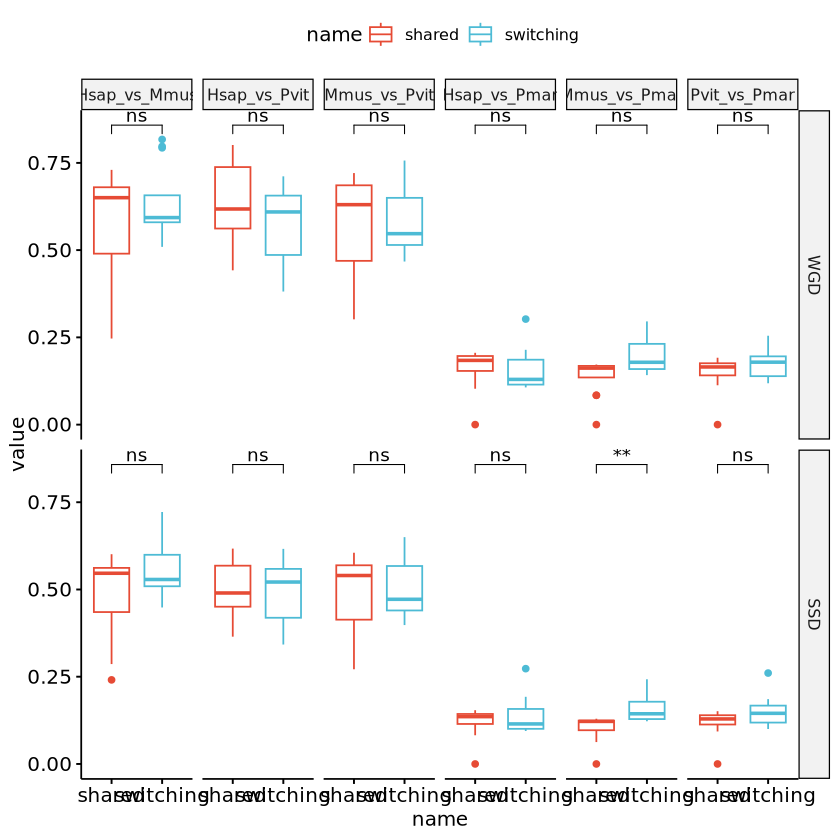

In [3]:
my_comparisons <- list(c("shared", "switching"))
p <- switching_pct %>% filter(cluster %in% Vertebrate_homologous_celltypes) %>% 
    pivot_longer(cols = c(shared, switching)) %>% 
        ggboxplot(x = "name", y = "value", color = "name", palette = "npg") + 
        stat_compare_means(method = 'wilcox.test', comparisons = list(c("shared", "switching")), paired = TRUE, label = "p.signif") + 
        facet_grid(vars(type), vars(species)) 
p
ggsave("paralog_switching_ratio.across_species.pdf", p, width = 8, height = 6)

Warning message in wilcox.test.default(c(0.139954853273138, 0.183460457647531, 0.196567862714509, :
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(c(0.0840390879478827, 0.163761467889908, :
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(c(0.131895687061184, 0.165194346289753, 0.191623864085342, :
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(c(0.139954853273138, 0.183460457647531, 0.196567862714509, :
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(c(0.0840390879478827, 0.163761467889908, :
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(c(0.131895687061184, 0.165194346289753, 0.191623864085342, :
“cannot compute exact p-value with zeroes”


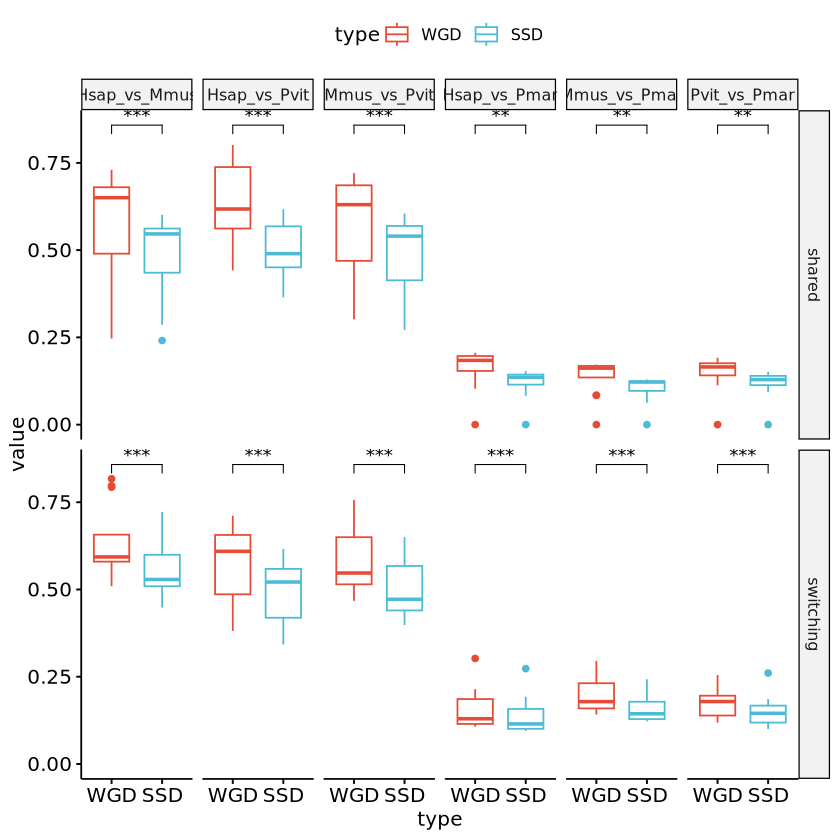

In [4]:
my_comparisons <- list(c("WGD", "SSD"))
p2 <- switching_pct %>% filter(cluster %in% Vertebrate_homologous_celltypes) %>% 
    pivot_longer(cols = c(shared, switching)) %>% 
        ggboxplot(x = "type", y = "value", color = "type", palette = "npg") + 
        stat_compare_means(method = 'wilcox.test', comparisons = list(c("WGD", "SSD")), paired = TRUE, label = "p.signif") + 
        facet_grid(vars(name), vars(species)) 
p2
ggsave("paralog_switching_ratio.SSD_WGD.pdf", p2, width = 8, height = 6)

In [10]:
save.image(file = "paralog.switching.RData")

In [2]:
load('paralog.switching.RData')

In [ ]:
# testing for finding good cases

In [ ]:
info_wgd

In [4]:
tmp <- read.delim('/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/01.data/03.markers/3.nsforest/Hsap/Hsap.TFs.Refined_family_supplementary.csv', sep = ',')

In [13]:
ops <- Reduce(rbind,lapply(unique(tmp$binary_genes), FUN = function(x){
    info_wgd_Hsap2Mmus[info_wgd_Hsap2Mmus$gene == x & info_wgd_Hsap2Mmus$markers & !info_wgd_Hsap2Mmus$orthologs_is_marker, ]
}))

In [23]:
info_wgd_Hsap2Mmus %>% filter(markers & !orthologs_is_marker) %>% filter(orthologs == 'Grin3a')

gene,markers,species,orthogroup_index,cluster,orthologs,orthologs_is_marker
<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<lgl>
ENSG00000198785,TRUE,Hsap,4249,Rhombencephalon glutamatergic neurons,Grin3a,FALSE
ENSG00000198785,TRUE,Hsap,4249,Splatter,Grin3a,FALSE


In [245]:
ops <- info_wgd_Hsap2Mmus %>% filter(orthogroup_index == 1896)

In [6]:
plot_marker_usage <- function(family_results, genes, clusters){
    tmp <- family_results %>% filter(gene %in% genes) %>% select("gene","cluster", "markers")
    new <- expand.grid(gene = genes, cluster = clusters, markers = NA)
    new <- merge(new, tmp, by = c("gene", "cluster"), all.x = TRUE)
    p <- new %>% ggplot(aes(x = as.factor(cluster), y = gene, fill = markers.y)) +
        geom_tile() + scale_fill_manual(values = c("TRUE" = "red", "FALSE" = "grey50", "NA" = "grey50")) +
        labs(x = "Cluster", y = "Gene", fill = "Marker") + theme_minimal() + 
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
    return(p)
}

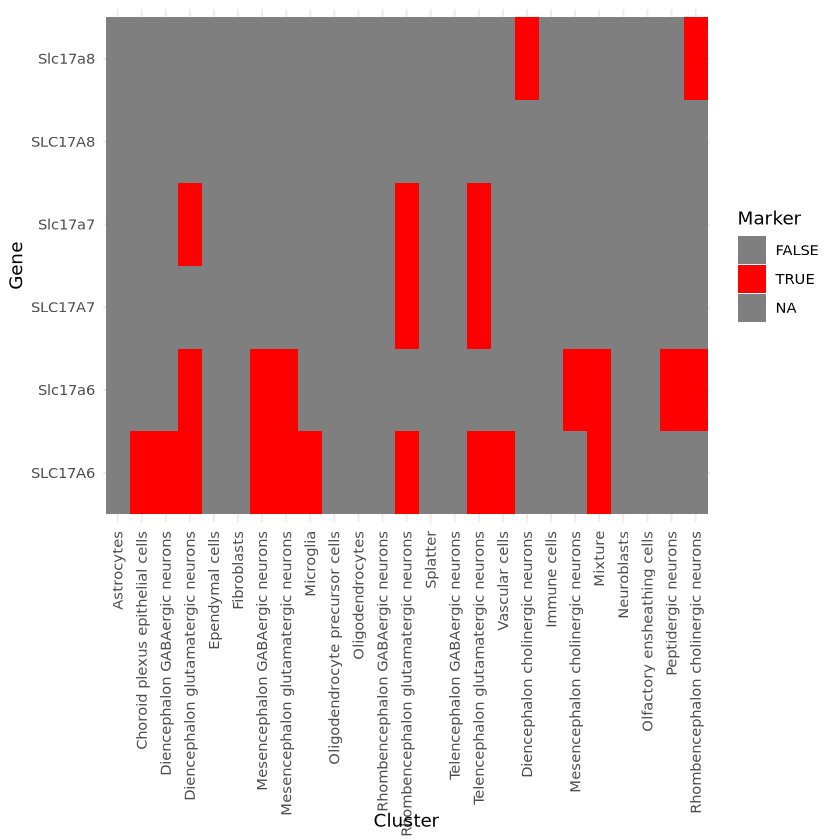

In [7]:
genes <- c('SLC17A6','Slc17a6','SLC17A7','Slc17a7','SLC17A8','Slc17a8')
#genes <- c('ENSG00000105329', 'ENSG00000119699', 'ENSG00000092969', 'Tgfb1','Tgfb3', 'Tgfb2')
#genes <- c('ENSG00000105643','ENSG00000113369','ENSG00000140450','ENSG00000197070','ENSG00000265972')
p <- plot_marker_usage(info_wgd_Mmus2Pvit, genes = genes, clusters = unique(info_wgd_Hsap2Mmus$cluster))
#ggsave(filename = "test.marker_usage.pdf", p, width = 6, height = 3)
p

In [35]:
head(switching_pct)

species,type,cluster,total_number,shared,switching
<fct>,<fct>,<chr>,<int>,<dbl>,<dbl>
Hsap_vs_Mmus,SSD,Astrocytes,1712,0.2862150,0.7207944
Hsap_vs_Mmus,SSD,Choroid plexus epithelial cells,2203,0.5342714,0.5215615
Hsap_vs_Mmus,SSD,Diencephalon GABAergic neurons,2269,0.6011459,0.4543852
Hsap_vs_Mmus,SSD,Diencephalon cholinergic neurons,2028,0.0000000,0.9097633
Hsap_vs_Mmus,SSD,Diencephalon glutamatergic neurons,2395,0.6004175,0.4605428
Hsap_vs_Mmus,SSD,Ependymal cells,2111,0.5466604,0.5286594


In [47]:
details_switching$test <- paste(details_switching$shared, details_switching$switching, sep = '_')
table(details_switching$test)


  NO_NO  NO_YES  YES_NO YES_YES 
 227370  175873   81804   42586 

In [48]:
head(details_switching)

cluster,orthogroup_index,shared,switching,species,type,test
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Astrocytes,1000,NO,YES,Hsap_vs_Mmus,WGD,NO_YES
Astrocytes,1001,NO,YES,Hsap_vs_Mmus,WGD,NO_YES
Astrocytes,1003,NO,YES,Hsap_vs_Mmus,WGD,NO_YES
Astrocytes,1010,YES,NO,Hsap_vs_Mmus,WGD,YES_NO
Astrocytes,1011,YES,NO,Hsap_vs_Mmus,WGD,YES_NO
Astrocytes,1028,YES,YES,Hsap_vs_Mmus,WGD,YES_YES


In [54]:
genes <- read.delim('/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/01.data/03.markers/3.nsforest/Hsap/Hsap.markers.Refined_family_supplementary.csv', sep = ',')

In [46]:
head(genes)

,clusterName,binary_genes,rf_feature_importance,cluster_median,binary_score
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Astrocytes,Cldn10,0.014728788,1.614098,0.9866720
2,Astrocytes,Fgfr3,0.020052851,1.744010,0.9820579
3,Astrocytes,Ntsr2,0.035770687,2.570243,0.9766450
4,Astrocytes,Acsbg1,0.015558778,1.631895,0.9757580
5,Astrocytes,Itih3,0.006783459,1.003065,0.9746788
6,Astrocytes,S1pr1,0.008314295,1.257179,0.9722109


In [55]:
ops <-Reduce(rbind, lapply(1:nrow(genes), FUN = function(x){
    g <- unlist(genes[x, 2])
    c <- unlist(genes[x, 1])
    res <- info_wgd_Hsap2Mmus %>% filter(gene  == g & markers!=orthologs_is_marker & cluster == c)
    return(res)
}))

In [76]:
ops %>% filter(cluster %in% Vertebrate_homologous_celltypes & cluster == 'Telencephalon glutamatergic neurons') 

gene,markers,species,orthogroup_index,cluster,orthologs,orthologs_is_marker
<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<lgl>
ENSG00000160963,TRUE,Hsap,3672,Telencephalon glutamatergic neurons,Col26a1,FALSE
ENSG00000198108,TRUE,Hsap,2310,Telencephalon glutamatergic neurons,Chsy3,FALSE
